In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
from pathlib import Path
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742840567.291645    8577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742840567.295096    8577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742840569.103317    8577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]

In [3]:
def plot_S1(distribution, q, end_index = 101, ci = True, show_sims = True, color = "red", ax = None, outliers = 0):
    tv = np.arange(0, 12, 0.1)
    
    # s_t_xie = np.array([0, 2.062, 3.36, 4.495, 6.32, 12.2])
    # alpha_xie = np.array([0.02872308, 0.04870019, 0.10390695, 0.16946955, 0.5868493 , 1])
    # S1_tv_xie = S1(tv, alpha_xie, s_t_xie)
    
    if(ax is None):
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

    S1_table = np.zeros((end_index-1, len(tv)))
    
    for i in range(1, end_index):
        data_alpha_s = pd.read_csv("OASIS - Results2/{}/{}/alpha_s.csv".format(distribution, i))
        alpha = data_alpha_s["alpha"].to_numpy()
        s_t = data_alpha_s["s"].to_numpy()
        
        S1_tv = S1(tv, alpha, s_t)
        S1_table[i-1, :] = S1_tv

        if(show_sims):
            ax.plot(tv, S1_tv, color = color, alpha = 0.1)
    
    # Obtain the median survival curve
    S1_median = np.quantile(S1_table, 0.50, axis = 0)
    # Takes the mean squared distances of all curves to the median
    median_distances = np.mean( (S1_table - S1_median)**2, axis = 1 )
    # Sorts the distances vector to get the ranks of each curve (i.e. sorts the curves by distance from the median curve)
    index_sort_distances = np.argsort(np.argsort( median_distances ))
    
    # Remove from the table of curves the prespecified number of outlier curves (which are discarded for the predictions)
    S1_table = S1_table[ index_sort_distances < (end_index - 1 - outliers) , :]    
    
    S1_q025 = np.quantile(S1_table, q = 0.05, axis = 0)
    S1_median = np.median(S1_table, axis = 0)
    S1_mean = np.mean(S1_table, axis = 0)
    S1_q975 = np.quantile(S1_table, q = 0.975, axis = 0)

    ax.plot(tv, S1_mean, color = color, label = distribution)
    if(ci):
        ax.plot(tv, S1_q025, color = color, linestyle = "dashed")
        ax.plot(tv, S1_q975, color = color, linestyle = "dashed")
    
    # ax.plot(tv, S1_tv_xie, color = "black")

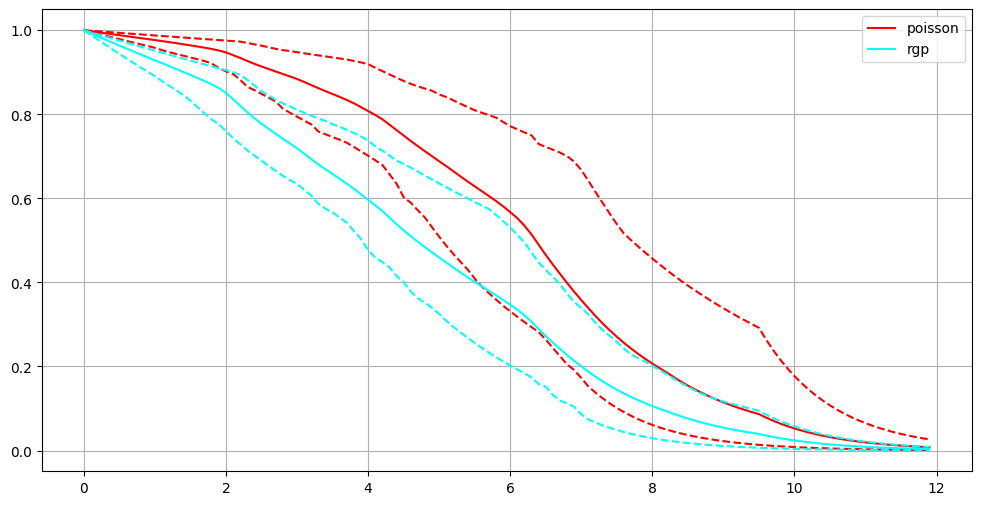

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

plot_S1("poisson", None, 101, ci = True, show_sims = False, color = "red", ax = ax, outliers = 0)
# plot_S1("haight", None, 101, ci = True, show_sims = False, color = "blue", ax = ax, outliers = 0)
# plot_S1("borel", None, 101, ci = True, show_sims = True, color = "green", ax = ax, outliers = 0)
# plot_S1("geometric", None, 101, ci = True, show_sims = False, color = "purple", ax = ax, outliers = 0)
# plot_S1("bernoulli", None, 101, ci = True, show_sims = False, color = "orange", ax = ax, outliers = 0)
# plot_S1("mvnb", 0.005, 101, ci = True, show_sims = False, color = "pink", ax = ax, outliers = 0)
plot_S1("rgp", -1/4, 101, ci = True, show_sims = False, color = "cyan", ax = ax, outliers = 0)

plt.grid()
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import roc_curve, auc

def ROC_estimate_FI(pred_p):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    tpr = np.sum( (pred_p <= thresholds) * (1-pred_p), axis = 0 ) / np.sum( 1-pred_p )
    fpr = np.sum( (pred_p <= thresholds) * pred_p, axis = 0 ) / np.sum( pred_p )
    return fpr, tpr, thresholds

def AUC_estimate_FI(pred_p):
    fpr, tpr, thresholds = ROC_estimate_FI(pred_p)
    return auc(fpr, tpr)

def ROC_estimate_MSI(pred_p, delta):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    
    pred_v = np.ones_like(pred_p)
    pred_y = np.ones_like(pred_p)
    pred_v[delta == 1] = 1
    pred_y[delta == 1] = 1
    pred_v[delta == 0] = 0
    pred_y[delta == 0] = -1 # If delta_i is zero, then v_i = 0 and therefore y_i is unknown
    
    tpr = np.sum( (pred_p <= thresholds) * (pred_v * pred_y + (1-pred_v)*(1-pred_p)), axis = 0 ) / np.sum( (pred_v * pred_y + (1-pred_v)*(1-pred_p)) )
    fpr = np.sum( (pred_p <= thresholds) * (pred_v * (1-pred_y) + (1-pred_v)*pred_p), axis = 0 ) / np.sum( pred_v * (1-pred_y) + (1-pred_v)*pred_p )
    return fpr, tpr, thresholds

def AUC_estimate_MSI(pred_p, delta):
    fpr, tpr, thresholds = ROC_estimate_MSI(pred_p, delta)
    return auc(fpr, tpr)

In [6]:
def load_fitted_model(distribution, q, images, file_index):
    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)

    simulation_path = "OASIS - Results/{}/{}".format(distribution, file_index)

    # ----------------------- Load data -----------------------
    # Indices for the images associated to this specific sample
    df_sample = pd.read_csv("OASIS - Small Dataset/bootstrap_sample/sample_{}.csv".format(file_index))

    imgs = images[ df_sample["image_index"] ]
    
    # ----------------------- Load results related to the fitted simulation ----------------------- 
    fitted_model = MPScrModel(log_a_tf, log_phi_tf, C_tf, C_inv_tf, sup_tf)
    fitted_model.define_structure(shape_input = images[0].shape)
    fitted_model.load_model("OASIS - Results2/{}/{}/model.weights.h5".format(distribution, file_index))
    alpha_s_df = pd.read_csv("OASIS - Results2/{}/{}/alpha_s.csv".format(distribution, file_index))
    pred_alpha = alpha_s_df["alpha"].to_numpy()
    s_t = alpha_s_df["s"].to_numpy()

    # ----------------------- Join everything in a single table -----------------------
    log_a_0 = log_a_tf(tf.constant(0.0, dtype = tf.float64))

    t = df_sample["time"].to_numpy()
    delta = df_sample["delta"].to_numpy()
    
    # Obtain all the predictions made using the trained model
    pred_eta = fitted_model.predict(imgs, verbose = 0)
    pred_p = fitted_model.link_func( pred_eta ).numpy().flatten()
    pred_log_p = np.log(pred_p)
    pred_theta = C_inv_tf( np.exp( log_a_0 - pred_log_p ) ).numpy().flatten()
    pred_m = update_m_mps(fitted_model, pred_alpha, s_t, imgs, t, delta)

    pred_S1 = S1(t, pred_alpha, s_t)

    AUC_FI_train = AUC_estimate_FI( pred_p[df_sample["set"] == "train"] )
    AUC_FI_test = AUC_estimate_FI( pred_p[df_sample["set"] == "test"] )
    AUC_MSI_train = AUC_estimate_MSI( pred_p[df_sample["set"] == "train"], delta[df_sample["set"] == "train"] )
    AUC_MSI_test = AUC_estimate_MSI( pred_p[df_sample["set"] == "test"], delta[df_sample["set"] == "test"] )

    pred_Spop = Spop(t, pred_alpha, s_t, log_a_tf, log_phi_tf, pred_theta, sup_tf)
    pred_fpop = fpop(t, pred_alpha, s_t, log_a_tf, log_phi_tf, pred_theta, sup_tf)
    
    obs_loglik_pred_terms = delta*np.log(pred_fpop) + (1-delta)*np.log(pred_Spop)
    
    obs_loglik_pred_train = np.sum( obs_loglik_pred_terms[df_sample["set"] == "train"] )
    obs_loglik_pred_test = np.sum( obs_loglik_pred_terms[df_sample["set"] == "test"] )

    df_summary = pd.DataFrame({"pred_theta": pred_theta, "pred_p": pred_p, "pred_m": pred_m,
                               "t": t, "delta": delta,
                               "pred_S1": pred_S1, "pred_Spop": pred_Spop,
                               "set": df_sample["set"].to_numpy()})
    
    return {
        "fit_model": fitted_model,
        "pred_alpha": pred_alpha,
        "pred_s_t": s_t,
        "imgs": imgs,
        "sets": df_sample["set"].to_numpy(),
        "log_a": log_a_tf,
        "log_phi": log_phi_tf,
        "C": C_tf,
        "C_inv": C_inv_tf,
        "sup": sup_tf,
        "summary": df_summary,
        "AUC_FI_train": AUC_FI_train,
        "AUC_FI_test": AUC_FI_test,
        "AUC_MSI_train": AUC_MSI_train,
        "AUC_MSI_test": AUC_MSI_test,
        "deviance_train": -2*obs_loglik_pred_train,
        "deviance_test": -2*obs_loglik_pred_test
    }

I0000 00:00:1742840569.788173    8577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1742840570.588455    8679 service.cc:148] XLA service 0x7b5ae0005f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742840570.588486    8679 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1742840570.607417    8679 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742840571.349918    8679 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


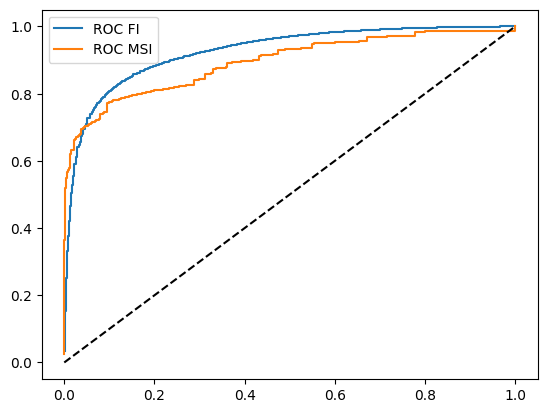

In [7]:
result = load_fitted_model("logarithmic", None, img_oasis, 1)
fpr_FI, tpr_FI, thresholds_FI = ROC_estimate_FI(result["summary"]["pred_p"])
fpr_MSI, tpr_MSI, thresholds_MSI = ROC_estimate_MSI(result["summary"]["pred_p"], result["summary"]["delta"])

plt.step(fpr_FI, tpr_FI, label = "ROC FI")
plt.step(fpr_MSI, tpr_MSI, label = "ROC MSI")
plt.plot([0,1], [0,1], linestyle = "dashed", color = "black")
plt.legend()
plt.show()

In [8]:
def recover_AUCs(distribution, q, images, end_index = 101):
    AUC_FI_train = []
    AUC_MSI_train = []
    AUC_FI_test = []
    AUC_MSI_test = []
    deviance_train = []
    deviance_test = []
    for j in tqdm(range(1, end_index)):
        results = load_fitted_model(distribution, q, images, j)
        AUC_FI_train.append( results["AUC_FI_train"] )
        AUC_FI_test.append( results["AUC_FI_test"] )
        AUC_MSI_train.append( results["AUC_MSI_train"] )
        AUC_MSI_test.append( results["AUC_MSI_test"] )
        deviance_train.append( results["deviance_train"] )
        deviance_test.append( results["deviance_test"] )
        
    AUC_FI_train = np.array(AUC_FI_train)
    AUC_FI_test = np.array(AUC_FI_test)
    AUC_MSI_train = np.array(AUC_MSI_train)
    AUC_MSI_test = np.array(AUC_MSI_test)
    deviance_train = np.array(deviance_train)
    deviance_test = np.array(deviance_test)

    return AUC_FI_train, AUC_FI_test, AUC_MSI_train, AUC_MSI_test, deviance_train, deviance_test

In [9]:
AUC_FI_train_poisson, AUC_FI_test_poisson, AUC_MSI_train_poisson, AUC_MSI_test_poisson, deviance_train_poisson, deviance_test_poisson \
= recover_AUCs("poisson", None, img_oasis, 101)
AUC_FI_train_geometric, AUC_FI_test_geometric, AUC_MSI_train_geometric, AUC_MSI_test_geometric, deviance_train_geometric, deviance_test_geometric \
= recover_AUCs("geometric", None, img_oasis, 101) 
AUC_FI_train_bernoulli, AUC_FI_test_bernoulli, AUC_MSI_train_bernoulli, AUC_MSI_test_bernoulli, deviance_train_bernoulli, deviance_test_bernoulli \
= recover_AUCs("bernoulli", None, img_oasis, 101) 
AUC_FI_train_borel, AUC_FI_test_borel, AUC_MSI_train_borel, AUC_MSI_test_borel, deviance_train_borel, deviance_test_borel \
= recover_AUCs("borel", None, img_oasis, 101) 
AUC_FI_train_haight, AUC_FI_test_haight, AUC_MSI_train_haight, AUC_MSI_test_haight, deviance_train_haight, deviance_test_haight \
= recover_AUCs("haight", None, img_oasis, 101) 
AUC_FI_train_logarithmic, AUC_FI_test_logarithmic, AUC_MSI_train_logarithmic, AUC_MSI_test_logarithmic, deviance_train_logarithmic, deviance_test_logarithmic \
= recover_AUCs("logarithmic", None, img_oasis, 101)
AUC_FI_train_mvnb, AUC_FI_test_mvnb, AUC_MSI_train_mvnb, AUC_MSI_test_mvnb, deviance_train_mvnb, deviance_test_mvnb \
= recover_AUCs("mvnb", 0.005, img_oasis, 101)
AUC_FI_train_rgp, AUC_FI_test_rgp, AUC_MSI_train_rgp, AUC_MSI_test_rgp, deviance_train_rgp, deviance_test_rgp \
= recover_AUCs("rgp", -1/4, img_oasis, 101)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


In [38]:
models = np.concatenate([np.repeat("poisson", len(AUC_FI_train_poisson)), np.repeat("geometric", len(AUC_FI_train_geometric)),
                         np.repeat("bernoulli", len(AUC_FI_train_bernoulli)), np.repeat("borel", len(AUC_FI_train_borel)),
                         np.repeat("haight", len(AUC_FI_train_haight)), np.repeat("logarithmic", len(AUC_FI_train_logarithmic)),
                         np.repeat("mvnb", len(AUC_FI_train_mvnb)), np.repeat("rgp", len(AUC_FI_train_rgp))])
AUC_FI_train_metrics = np.concatenate([AUC_FI_train_poisson, AUC_FI_train_geometric, AUC_FI_train_bernoulli,
                                       AUC_FI_train_borel, AUC_FI_train_haight, AUC_FI_train_logarithmic,
                                       AUC_FI_train_mvnb, AUC_FI_train_rgp])
AUC_FI_test_metrics = np.concatenate([AUC_FI_test_poisson, AUC_FI_test_geometric, AUC_FI_test_bernoulli,
                                       AUC_FI_test_borel, AUC_FI_test_haight, AUC_FI_test_logarithmic,
                                       AUC_FI_test_mvnb, AUC_FI_test_rgp])
AUC_MSI_train_metrics = np.concatenate([AUC_MSI_train_poisson, AUC_MSI_train_geometric, AUC_MSI_train_bernoulli,
                                        AUC_MSI_train_borel, AUC_MSI_train_haight, AUC_MSI_train_logarithmic,
                                        AUC_MSI_train_mvnb, AUC_MSI_train_rgp])
AUC_MSI_test_metrics = np.concatenate([AUC_MSI_test_poisson, AUC_MSI_test_geometric, AUC_MSI_test_bernoulli,
                                       AUC_MSI_test_borel, AUC_MSI_test_haight, AUC_MSI_test_logarithmic,
                                       AUC_MSI_test_mvnb, AUC_MSI_test_rgp])
deviance_train_metrics = np.concatenate([deviance_train_poisson, deviance_train_geometric, deviance_train_bernoulli,
                                         deviance_train_borel, deviance_train_haight, deviance_train_logarithmic, 
                                         deviance_train_mvnb, deviance_train_rgp])
deviance_test_metrics = np.concatenate([deviance_test_poisson, deviance_test_geometric, deviance_test_bernoulli,
                                         deviance_test_borel, deviance_test_haight, deviance_test_logarithmic, 
                                         deviance_test_mvnb, deviance_test_rgp])

auc_metrics_oasis = pd.DataFrame({
    "Model": models,
    "AUC_FI_train": AUC_FI_train_metrics,
    "AUC_MSI_train": AUC_MSI_train_metrics,
    "deviance_train": deviance_train_metrics,
    "AUC_FI_test": AUC_FI_test_metrics,
    "AUC_MSI_test": AUC_MSI_test_metrics,
    "deviance_test": deviance_test_metrics
})
auc_metrics_oasis

Model  AUC_FI_train  AUC_MSI_train  deviance_train  AUC_FI_test  \
0    poisson      0.998636       0.999470      132.750062     0.981857   
1    poisson      0.993889       0.995744      175.938216     0.943926   
2    poisson      0.969914       0.971854      173.223286     0.942930   
3    poisson      0.988929       0.991480      170.681831     0.910062   
4    poisson      0.992477       0.994171      145.561507     0.951245   
..       ...           ...            ...             ...          ...   
795      rgp      0.885566       0.918663      163.124317     0.827159   
796      rgp      0.974741       0.983019      241.375227     0.863978   
797      rgp      0.987306       0.992827      236.753947     0.865028   
798      rgp      0.957033       0.965838      181.209191     0.812097   
799      rgp      0.956423       0.972286      231.084362     0.868193   

     AUC_MSI_test  deviance_test  
0        0.732086      70.771165  
1        0.804910      69.978398  
2        0.820649     103.984288  
3        0.807127      59.348531  
4        0.789490      49.562385  
..            ...            ...  
795      0.655687      62.133772  
796      0.786567      52.439814  
797      0.740863      43.556779  
798      0.796064      55.372233  
799      0.878662      28.999874  

[800 rows x 7 columns]

/tmp/ipykernel_8577/1706632168.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(models, rotation = 20)
/tmp/ipykernel_8577/1706632168.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(models, rotation = 20)
/tmp/ipykernel_8577/1706632168.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(models, rotation = 20)
/tmp/ipykernel_8577/1706632168.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(models, rotation = 20)


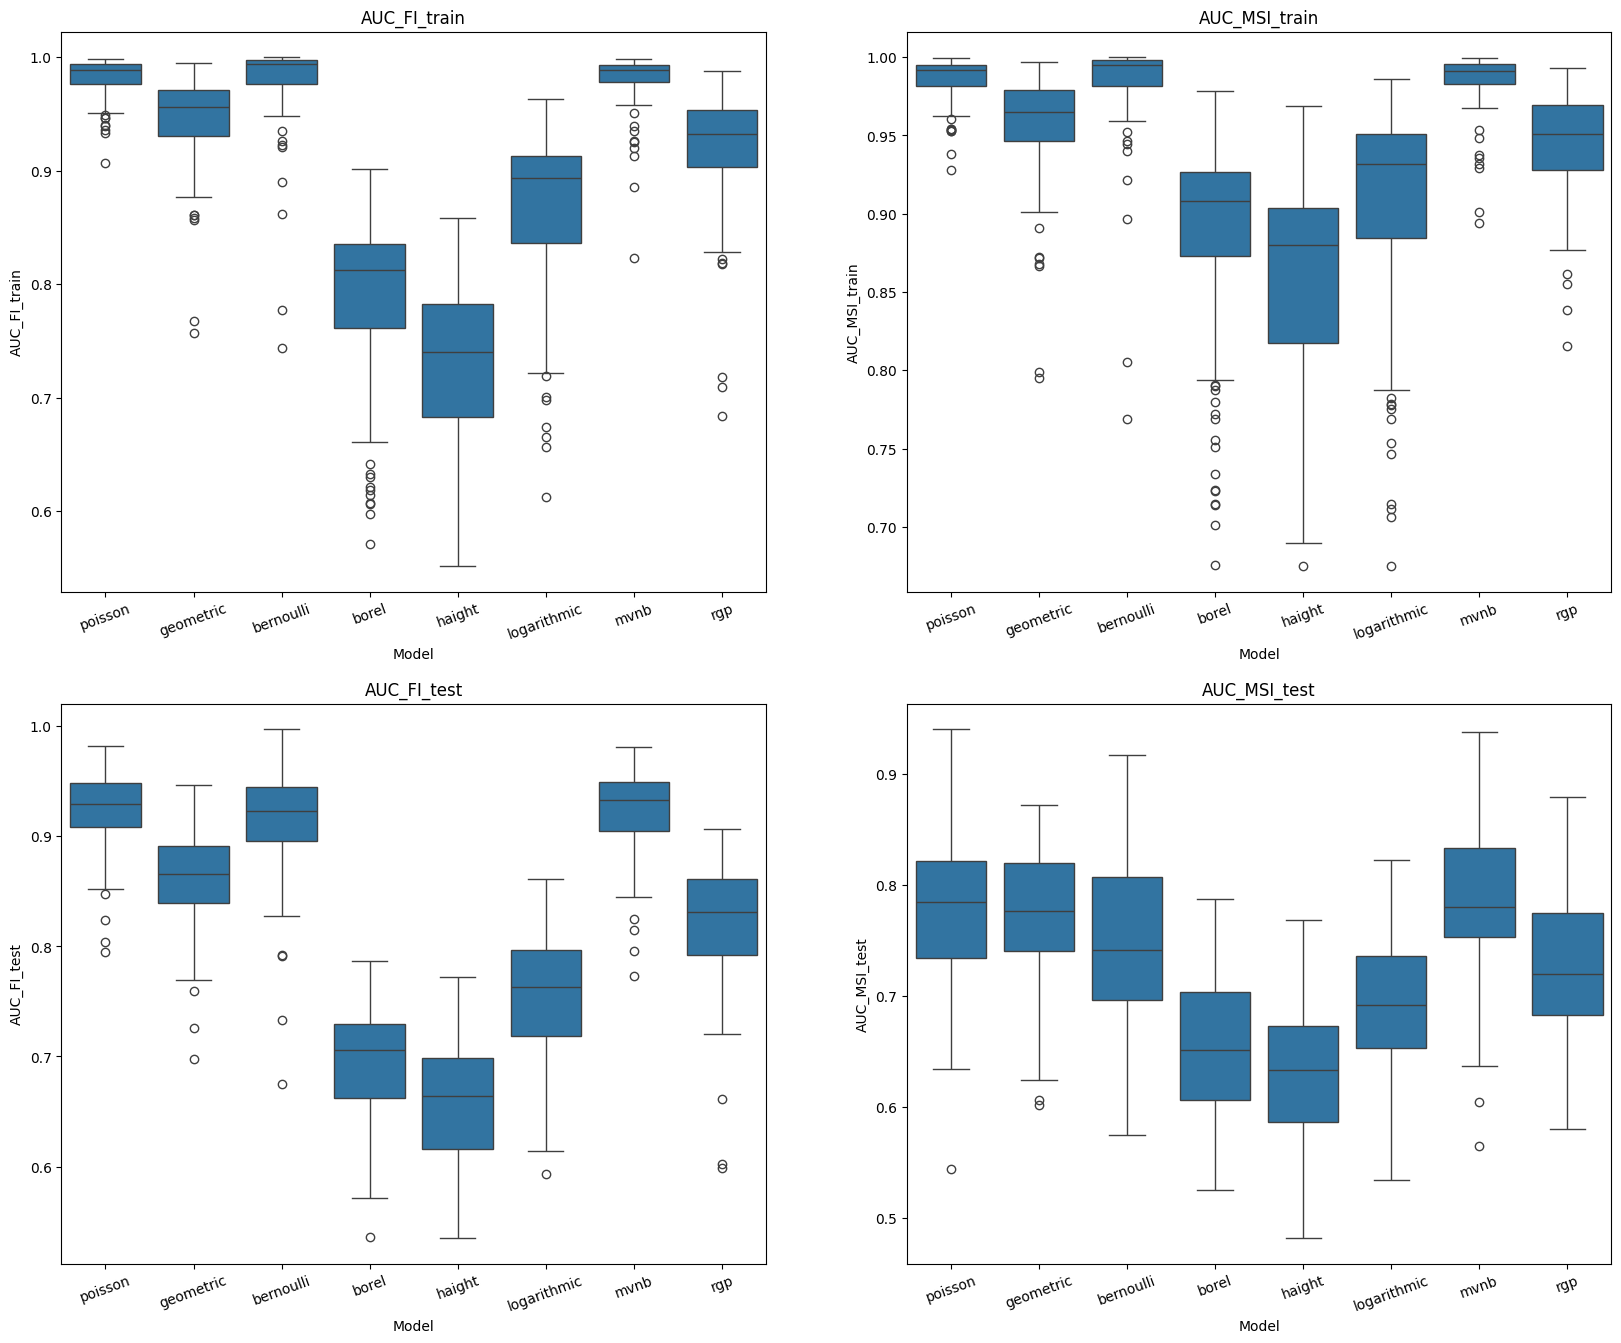

In [41]:
models = auc_metrics_oasis["Model"].unique()

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,16))

sns.boxplot(x = "Model", y = "AUC_FI_train", data = auc_metrics_oasis, ax = ax[0,0])
ax[0,0].set_title("AUC_FI_train")
ax[0,0].set_xticklabels(models, rotation = 20)
sns.boxplot(x = "Model", y = "AUC_FI_test", data = auc_metrics_oasis, ax = ax[1,0])
ax[1,0].set_title("AUC_FI_test")
ax[1,0].set_xticklabels(models, rotation = 20)

sns.boxplot(x = "Model", y = "AUC_MSI_train", data = auc_metrics_oasis, ax = ax[0,1])
ax[0,1].set_title("AUC_MSI_train")
ax[0,1].set_xticklabels(models, rotation = 20)
sns.boxplot(x = "Model", y = "AUC_MSI_test", data = auc_metrics_oasis, ax = ax[1,1])
ax[1,1].set_title("AUC_MSI_test")
ax[1,1].set_xticklabels(models, rotation = 20)

# sns.boxplot(x = "Model", y = "deviance_train", data = auc_metrics_oasis, ax = ax[0,2])
# ax[0,2].set_title("Deviance Train")
# ax[0,2].set_xticklabels(models, rotation = 20)
# sns.boxplot(x = "Model", y = "deviance_test", data = auc_metrics_oasis, ax = ax[1,2])
# ax[1,2].set_title("Deviance Test")
# ax[1,2].set_xticklabels(models, rotation = 20)

plt.show()

In [71]:
auc_metrics_oasis_melt = auc_metrics_oasis.melt(id_vars=["Model"], 
                                                value_vars=["AUC_FI_train", "AUC_FI_test", "AUC_MSI_train", "AUC_MSI_test"],
                                                var_name="metric", 
                                                value_name="AUC")
auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"].str.contains("train"), "set" ] = "train"
auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"].str.contains("test"), "set" ] = "test"

auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"] == "AUC_FI_train", "metric" ] = "AUC_FI"
auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"] == "AUC_FI_test", "metric" ] = "AUC_FI"
auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"] == "AUC_MSI_train", "metric" ] = "AUC_MSI"
auc_metrics_oasis_melt.loc[ auc_metrics_oasis_melt["metric"] == "AUC_MSI_test", "metric" ] = "AUC_MSI"

auc_metrics_oasis_melt.head()

Model  metric       AUC    set
0  poisson  AUC_FI  0.998636  train
1  poisson  AUC_FI  0.993889  train
2  poisson  AUC_FI  0.969914  train
3  poisson  AUC_FI  0.988929  train
4  poisson  AUC_FI  0.992477  train

/tmp/ipykernel_8577/1514416493.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(models, fontsize = 11)
/tmp/ipykernel_8577/1514416493.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(models, fontsize = 11)


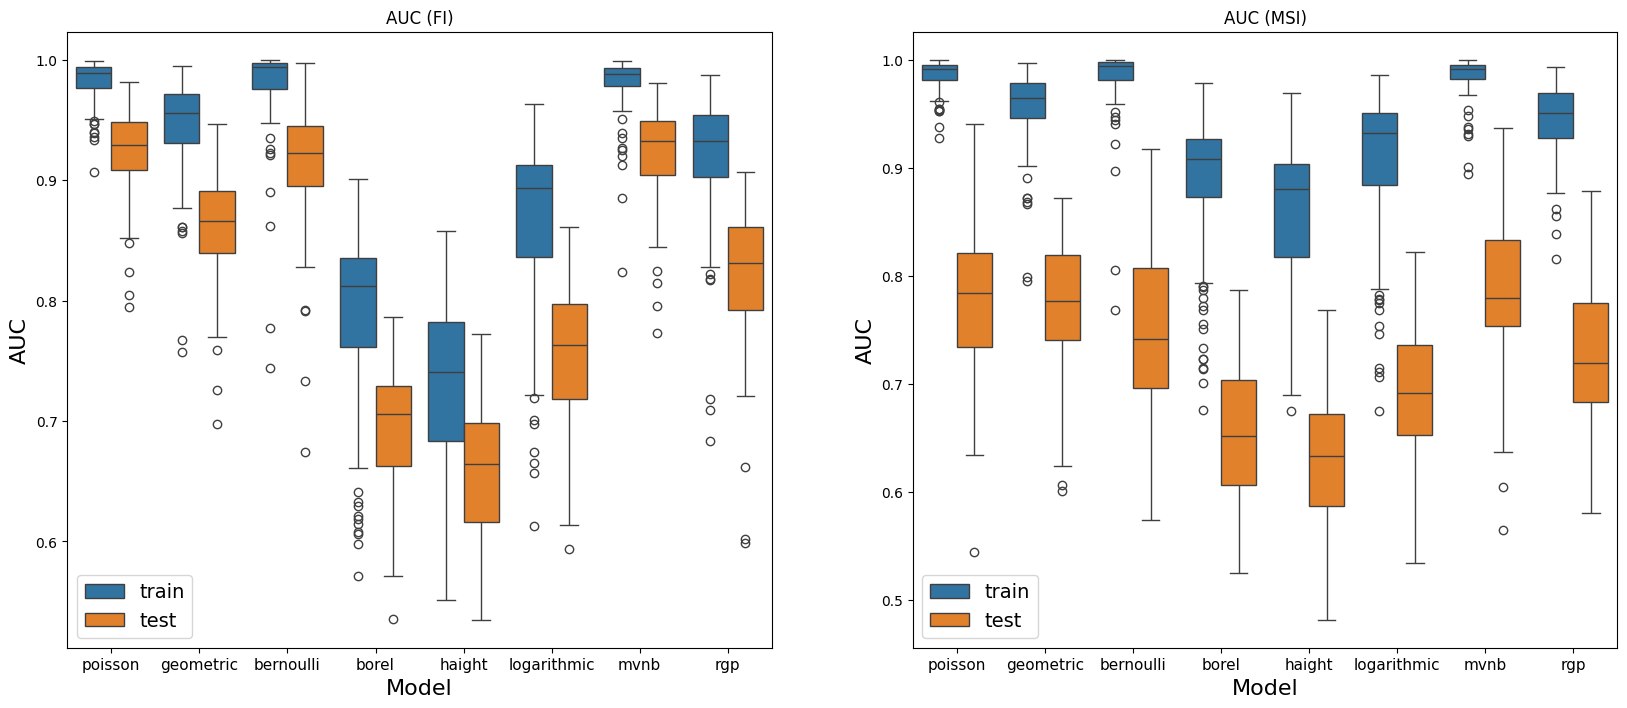

In [102]:
models = auc_metrics_oasis_melt["Model"].unique()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

sns.boxplot(x = "Model", y = "AUC", hue = "set", data = auc_metrics_oasis_melt.loc[auc_metrics_oasis_melt["metric"] == "AUC_FI"], ax = ax[0])
ax[0].set_title("AUC (FI)")
ax[0].legend(fontsize = 14)
ax[0].set_xticklabels(models, fontsize = 11)
ax[0].set_xlabel("Model", fontsize = 16)
ax[0].set_ylabel("AUC", fontsize = 16)

sns.boxplot(x = "Model", y = "AUC", hue = "set", data = auc_metrics_oasis_melt.loc[auc_metrics_oasis_melt["metric"] == "AUC_MSI"], ax = ax[1])
ax[1].set_title("AUC (MSI)")
ax[1].legend(fontsize = 14)
ax[1].set_xticklabels(models, fontsize = 11)
ax[1].set_xlabel("Model", fontsize = 16)
ax[1].set_ylabel("AUC", fontsize = 16)

plt.show()

In [ ]:
sns.boxplot(x = "Model", y = "AUC_MSI_train", data = auc_metrics_oasis, ax = ax[0,1])

In [54]:
np.round( auc_metrics_oasis.groupby("Model").mean().loc[:,["AUC_FI_test", "AUC_MSI_test"]], 4 )

AUC_FI_test  AUC_MSI_test
Model                                 
bernoulli         0.9122        0.7461
borel             0.6909        0.6524
geometric         0.8623        0.7737
haight            0.6567        0.6310
logarithmic       0.7528        0.6915
mvnb              0.9215        0.7837
poisson           0.9230        0.7836
rgp               0.8221        0.7237

In [48]:
img_oasis.shape

(352, 160, 200, 1)